In [82]:
import homophily_functions as fn
import logistic_func as fn_logit
import importlib
%matplotlib inline

from pathlib import Path
import networkx as nx
from collections import defaultdict
from collections import Counter
from tqdm import tqdm
import pickle as pk
import numpy as np
import pandas as pd
from datetime import datetime as dt
from geopy.distance import great_circle
import matplotlib.pyplot as plt
from random import sample
from random import choices
import seaborn as sns
import bisect
import math

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [87]:
importlib.reload(fn_logit)

<module 'logistic_func' from '/home/quint/twitter_network/Soc science paper/logistic_func.py'>

In [3]:
G = pk.load(open("/home/quint/twitter_network/Pickles/survey_followers_new.pk", "rb"))  

In [4]:
print(len(G.edges()), len(G))

58355 31526


In [5]:
G_flt = G.subgraph([node for node,deg in G.in_degree if deg<100]).copy()

In [6]:
G_flt_2 = G.subgraph([node for node,deg in G.in_degree if deg<50]).copy()

In [7]:
G_flt_3 = G.subgraph([node for node,deg in G.in_degree if deg<25]).copy()

In [8]:
G_flt_4 = G.subgraph([node for node,deg in G.in_degree if deg<15]).copy()

In [9]:
print(len(G_flt.edges()), len(G_flt))

9591 31435


In [10]:
print(len(G_flt_2.edges()), len(G_flt_2))

5868 31385


In [11]:
print(len(G_flt_3.edges()), len(G_flt_3))

4318 31341


In [12]:
print(len(G_flt_4.edges()), len(G_flt_4))

2894 31275


In [13]:
nodes_high = [(node,deg) for node,deg in G.in_degree if deg>100]

In [14]:
len(nodes_high)

90

In [19]:
sum([deg for node,deg, in nodes_high])

48308

### HOMOPHILY ESTIMATES ###

In [20]:
def get_freq_hom(attr, net = G):
    (dens, cnt_pairs, cnt_ties) = fn.diadic_density(attr, net)
    cnt_no_tie = {key:(val-cnt_ties[key]) for key,val in cnt_pairs.items()}   
    
    rows = [None for i in range(len(cnt_ties) + len(cnt_no_tie))]
    i = 0
    for key,val in cnt_ties.items():
        if key[0] == key[1]:
            Hom = key[0]
        if key[0] != key[1]:
            Hom = 0
        rows[i] = [key[0], key[1], 1, val, Hom]  
        i +=1

    for key,val in cnt_no_tie.items():
        if key[0] == key[1]:
            Hom = key[0]
        if key[0] != key[1]:
            Hom = 0
        rows[i] = [key[0], key[1], 0, val, Hom]  
        i +=1

    df = pd.DataFrame(rows, columns = ["Ego", "Alter", "Tie", "Freq", "Hom"])    
    return(df)

In [101]:
def get_mod_coefs(tab, r = 2):
    mod = smf.glm("Tie ~ C(Hom)", data = tab, family = sm.families.Binomial(), freq_weights = tab.Freq)
    res = mod.fit()
    t1 = np.exp(res.params)
    t1_ci = np.exp(res.params + res.bse*1.96) - t1
    
    mod = smf.glm("Tie ~ C(Ego) + C(Alter) + C(Hom)", data = tab, family = sm.families.Binomial(), freq_weights = tab.Freq)
    res = mod.fit()
    t2 = np.exp(res.params)
    t2_ci = np.exp(res.params + res.bse*1.96) - t2
    
    out = pd.concat([t1,t1_ci,  t2, t2_ci], axis=1).round(2)        
    return(out)

def get_coefs_grafs(attr, g, gend = False) :
      
    df = get_freq_hom(attr, g)
    if gend:
        df["Hom"] = df.Hom.apply(lambda x: 1 if x!=0 else 0)        
    tab = get_mod_coefs(df)
    tab = tab.loc[tab.index.map(lambda x: "Hom" in x),]
    return(tab)

def summarise_coefficients(tabs):
    mod1_max = pd.concat([t.iloc[:,0] for t in tabs], axis=1).max(axis=1)
    mod1_min = pd.concat([t.iloc[:,0] for t in tabs], axis=1).min(axis=1)
    mod1_ci = pd.concat([t.iloc[:,1] for t in tabs], axis=1).max(axis=1)
    
    mod1_res = pd.concat([mod1_min, mod1_max, mod1_ci], axis = 1)
    
    mod2_max = pd.concat([t.iloc[:,2] for t in tabs], axis=1).max(axis=1)
    mod2_min = pd.concat([t.iloc[:,2] for t in tabs], axis=1).min(axis=1)
    mod2_ci = pd.concat([t.iloc[:,3] for t in tabs], axis=1).max(axis=1)
    
    mod2_res = pd.concat([mod2_min, mod2_max, mod2_ci], axis = 1)

    return(mod1_res, mod2_res)

Partisanship

In [117]:
tabs = list(map(lambda g: get_coefs_grafs("party3", g), [G_flt, G_flt_2, G_flt_3, G_flt_4]))
summarise_coefficients(tabs)

100%|█████████████████████████████████████████████████████████████████████████████████████| 2886/2886 [00:00<00:00, 266009.48it/s]


(                                0     1     2
 C(Hom)[T.Democrat]           1.48  1.68  0.15
 C(Hom)[T.Independent/Other]  0.90  1.05  0.14
 C(Hom)[T.Republican]         1.33  1.55  0.22,
                                 0     1     2
 C(Hom)[T.Democrat]           1.50  1.56  0.29
 C(Hom)[T.Independent/Other]  0.84  0.91  0.20
 C(Hom)[T.Republican]         1.52  2.16  0.42)

In [113]:
tabs = list(map(lambda g: get_coefs_grafs("race", g), [G_flt, G_flt_2, G_flt_3, G_flt_4]))
summarise_coefficients(tabs)

100%|███████████████████████████████████████████████████████████████████████████████████████| 2894/2894 [00:00<00:00, 315248.18it/s]


(                               0     1     2
 C(Hom)[T.African American]  2.46  3.38  0.65
 C(Hom)[T.Asian]             1.74  2.36  0.89
 C(Hom)[T.Hispanic]          1.03  1.73  0.58
 C(Hom)[T.Other]             2.06  2.94  4.14
 C(Hom)[T.White]             1.27  1.82  0.14,
                                0     1     2
 C(Hom)[T.African American]  2.27  2.98  0.91
 C(Hom)[T.Asian]             2.79  3.28  1.77
 C(Hom)[T.Hispanic]          1.04  1.19  0.57
 C(Hom)[T.Other]             1.45  2.79  4.45
 C(Hom)[T.White]             1.52  1.90  0.42)

In [114]:
tabs = list(map(lambda g: get_coefs_grafs("gender", g, True), [G_flt, G_flt_2, G_flt_3, G_flt_4]))
summarise_coefficients(tabs)

100%|███████████████████████████████████████████████████████████████████████████████████████| 2894/2894 [00:00<00:00, 287985.85it/s]


(                0     1    2
 C(Hom)[T.1]  1.17  1.29  0.1,
                 0    1    2
 C(Hom)[T.1]  1.28  1.4  0.1)

In [115]:
tabs = list(map(lambda g: get_coefs_grafs("vote", g, False), [G_flt, G_flt_2, G_flt_3, G_flt_4]))
summarise_coefficients(tabs)

100%|███████████████████████████████████████████████████████████████████████████████████████| 2894/2894 [00:00<00:00, 304210.82it/s]


(                             0     1     2
 C(Hom)[T.Biden]           1.34  1.88  0.15
 C(Hom)[T.Other/Not sure]  0.75  1.32  0.30
 C(Hom)[T.Trump]           1.42  1.83  0.25,
                              0     1     2
 C(Hom)[T.Biden]           1.37  1.96  0.43
 C(Hom)[T.Other/Not sure]  0.86  1.13  0.36
 C(Hom)[T.Trump]           1.54  1.76  0.44)

In [116]:
tabs = list(map(lambda g: get_coefs_grafs("income_cat_4", g), [G_flt, G_flt_2, G_flt_3, G_flt_4]))
summarise_coefficients(tabs)

100%|███████████████████████████████████████████████████████████████████████████████████████| 2680/2680 [00:00<00:00, 323437.15it/s]


(                                0     1     2
 C(Hom)[T.100k and over]      1.05  1.29  0.21
 C(Hom)[T.25k to under 50k]   0.95  1.21  0.21
 C(Hom)[T.50k to under 100k]  1.04  1.30  0.16
 C(Hom)[T.Under 25k]          1.11  1.37  0.25,
                                 0     1     2
 C(Hom)[T.100k and over]      1.29  1.48  0.34
 C(Hom)[T.25k to under 50k]   1.00  1.22  0.28
 C(Hom)[T.50k to under 100k]  0.95  1.00  0.20
 C(Hom)[T.Under 25k]          1.25  1.55  0.38)

In [96]:
def get_feature_dyad_hom(arg):
    node1 = arg[0]
    node2 = arg[1]
    if pd.isna(node1['age']) or pd.isna(node2['age']):          
        return("NA")
    
    age_diff = np.abs(node2['age'] - node1['age'])
    age_ego = node1['age']
    age_alter = node2['age']
    age_diff_log = np.abs(math.log2(node2['age']) - math.log2(node1['age']))
    
    return(age_diff, age_ego, age_alter, age_diff_log)

def fit_age(G):
    neg_dyads, pos_dyads = fn_logit.get_random_dyads(G_flt, len(G_flt.edges())*1000, list(G_flt.nodes()))
    dyads = neg_dyads + pos_dyads
    args = ([G_flt.nodes[d[0]], G_flt.nodes[d[1]]] for d in dyads)
    
    out = list(map(get_feature_dyad_hom, args))
    NAs = [i for i,el in enumerate(out) if el=="NA"]
    y = np.array([0 for i in range(len(neg_dyads))] + [1 for i in range(len(pos_dyads))])
    X = pd.DataFrame(out, columns = ["age_diff", "age_ego", "age_alter", "age_diff_log"])
    X['y'] = y    
    
    mod = smf.logit(formula = "y ~ age_diff_log", data = X)
    res_age_diff = mod.fit(cov_type='HC3')

    p1 = np.exp(res_age_diff.params)
    p1_ci = np.exp(res_age_diff.params + res_age_diff.bse*1.96) - p1
    
    mod = smf.logit(formula = "y ~ age_diff_log + np.log2(age_ego) + np.log2(age_alter)", data = X)
    res_age_diff = mod.fit(cov_type='HC3')

    p2 = np.exp(res_age_diff.params)
    p2_ci = np.exp(res_age_diff.params + res_age_diff.bse*1.96) - p2

    return( [p1[1], p1_ci[1], p2[1], p2_ci[1]])

In [97]:
mod1 = fit_age(G_flt)

Optimization terminated successfully.
         Current function value: 0.007900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007893
         Iterations 11


/tmp/ipykernel_58308/2698265822.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return( [p1[1], p1_ci[1], p2[1], p2_ci[1]])


In [98]:
mod2 = fit_age(G_flt_2)

Optimization terminated successfully.
         Current function value: 0.007900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007894
         Iterations 11


/tmp/ipykernel_58308/2698265822.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return( [p1[1], p1_ci[1], p2[1], p2_ci[1]])


In [99]:
mod3 = fit_age(G_flt_3)

Optimization terminated successfully.
         Current function value: 0.007900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007894
         Iterations 11


/tmp/ipykernel_58308/2698265822.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return( [p1[1], p1_ci[1], p2[1], p2_ci[1]])


In [100]:
mod4 = fit_age(G_flt_4)

Optimization terminated successfully.
         Current function value: 0.007900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.007893
         Iterations 11


/tmp/ipykernel_58308/2698265822.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return( [p1[1], p1_ci[1], p2[1], p2_ci[1]])


In [104]:
pd.Series(mod1)

0    0.550749
1    0.027519
2    0.543605
3    0.027619
dtype: float64

In [106]:
age_tab = pd.concat([pd.Series(mod1), pd.Series(mod2), pd.Series(mod3), pd.Series(mod4)], axis = 1)

In [109]:
age_tab.max(axis = 1)

0    0.551322
1    0.027540
2    0.544308
3    0.027641
dtype: float64

In [110]:
age_tab.min(axis = 1)

0    0.550199
1    0.027468
2    0.543162
3    0.027567
dtype: float64

In [111]:
age_tab

,0,1,2,3
0,0.550749,0.550199,0.551322,0.550996
1,0.027519,0.027468,0.027540,0.027510
2,0.543605,0.543162,0.544308,0.543975
3,0.027619,0.027567,0.027641,0.027612


### HEATMAPS

100%|█████████████████████████████████████████████████████████████████████████████████████| 4318/4318 [00:00<00:00, 149499.81it/s]
/home/quint/twitter_network/Soc science paper/homophily_functions.py:108: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  vals = pd.unique([pair[0] for pair in pairs])


(<Figure size 1000x700 with 2 Axes>,
 <Axes: xlabel='Followed', ylabel='Follower'>)

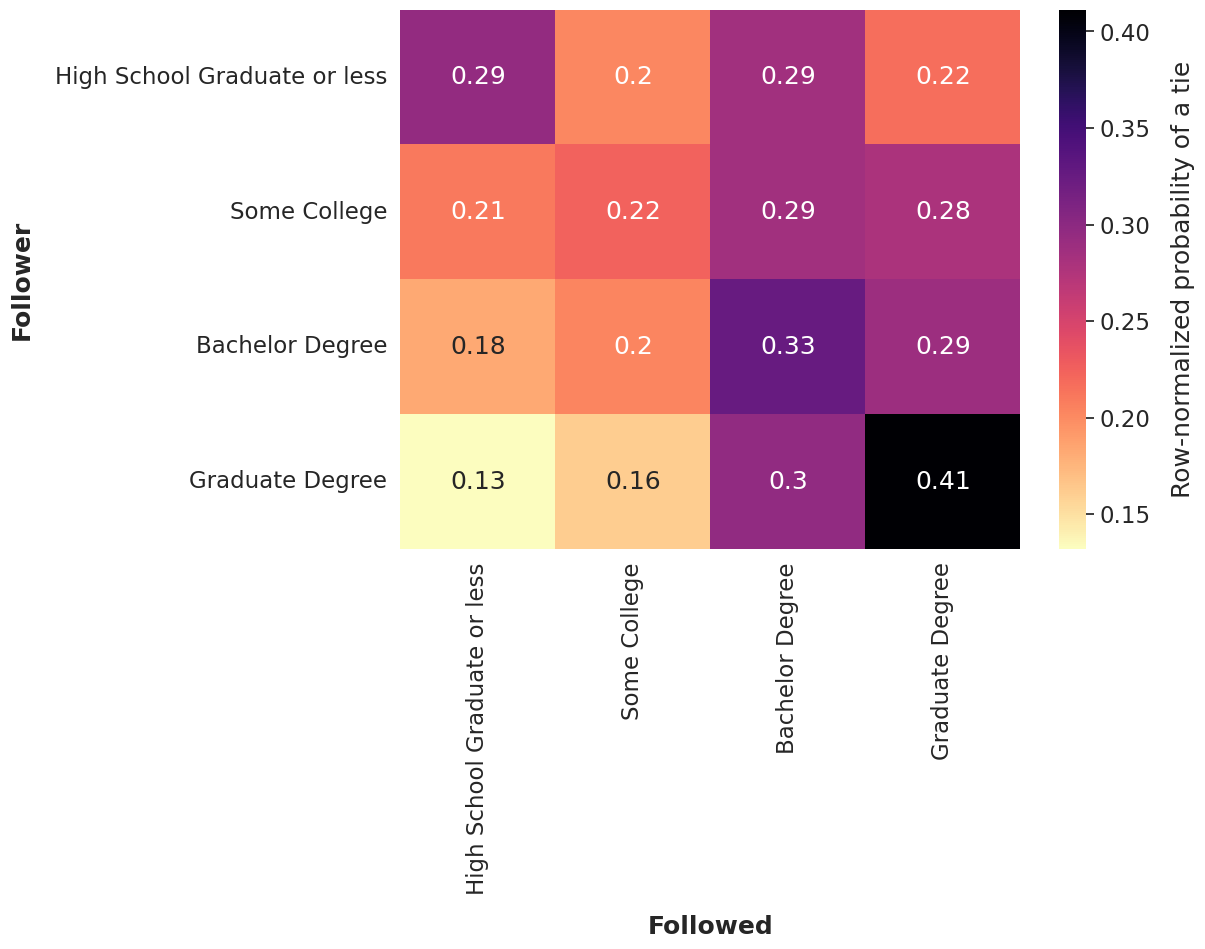

In [124]:
variable = "education"
col_names=['High School Graduate or less', 'Some College','Bachelor Degree','Graduate Degree' ]
edu = fn.get_table(fn.diadic_density(variable, G_flt_3)[0])
fn.genreate_heatmaps(variable, edu, size=(10,7), col_names = col_names, title=False, font_scale=1.5,
                 annotate=True, labelpad=15, color= "magma_r", norm = "Row",
                 file_name='Plots/Bivariate/CSP/'+variable+'_rownorm_G3.png')


100%|█████████████████████████████████████████████████████████████████████████████████████| 2894/2894 [00:00<00:00, 124856.67it/s]
/home/quint/twitter_network/Soc science paper/homophily_functions.py:108: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  vals = pd.unique([pair[0] for pair in pairs])


(<Figure size 1000x700 with 2 Axes>,
 <Axes: xlabel='Followed', ylabel='Follower'>)

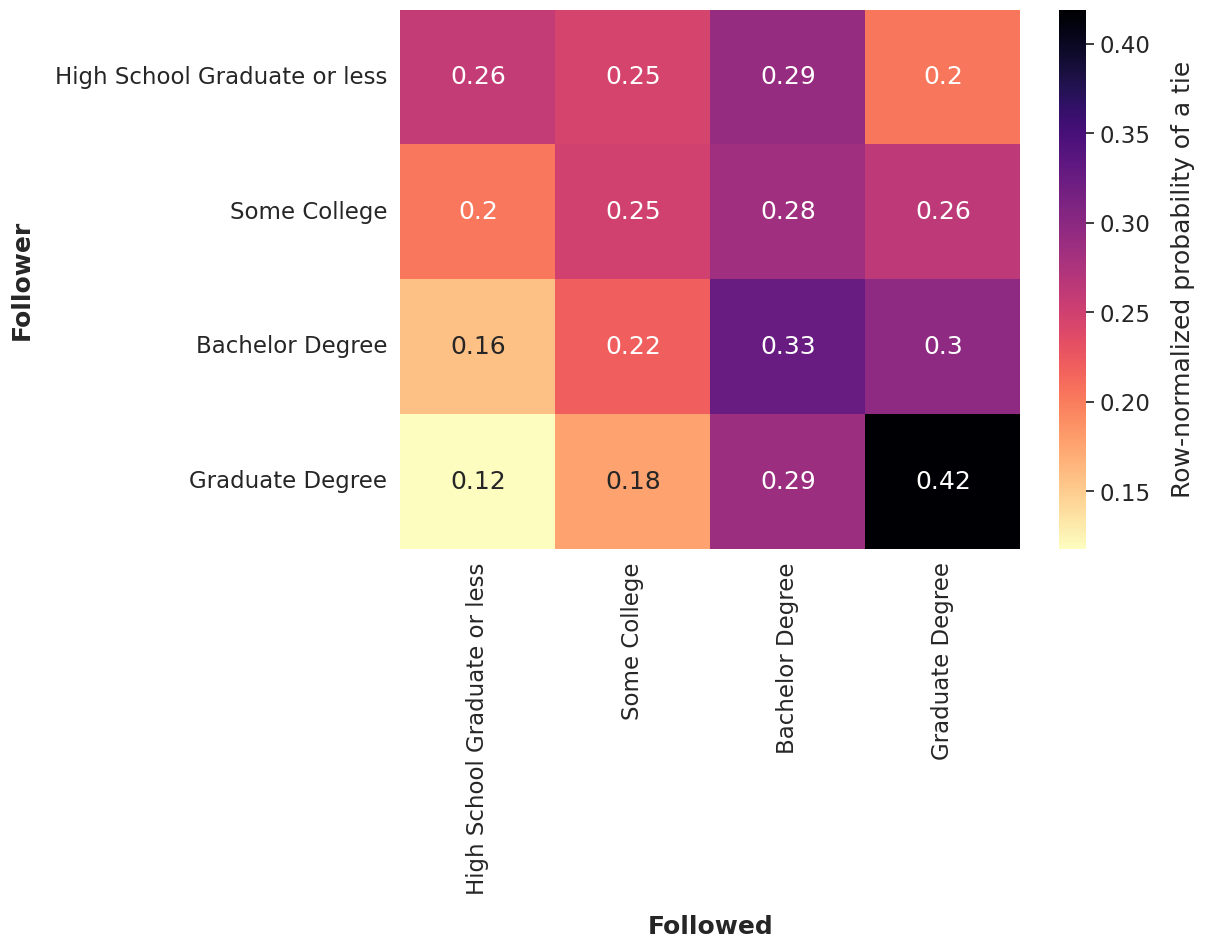

In [125]:
variable = "education"
col_names=['High School Graduate or less', 'Some College','Bachelor Degree','Graduate Degree' ]
edu = fn.get_table(fn.diadic_density(variable, G_flt_4)[0])
fn.genreate_heatmaps(variable, edu, size=(10,7), col_names = col_names, title=False, font_scale=1.5,
                 annotate=True, labelpad=15, color= "magma_r", norm = "Row")
                 #file_name='plots/bivariate/'+variable+'_rownorm_G3.png')


100%|█████████████████████████████████████████████████████████████████████████████████████| 3947/3947 [00:00<00:00, 164401.66it/s]
/home/quint/twitter_network/Soc science paper/homophily_functions.py:108: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  vals = pd.unique([pair[0] for pair in pairs])


(<Figure size 1000x700 with 2 Axes>,
 <Axes: xlabel='Followed', ylabel='Follower'>)

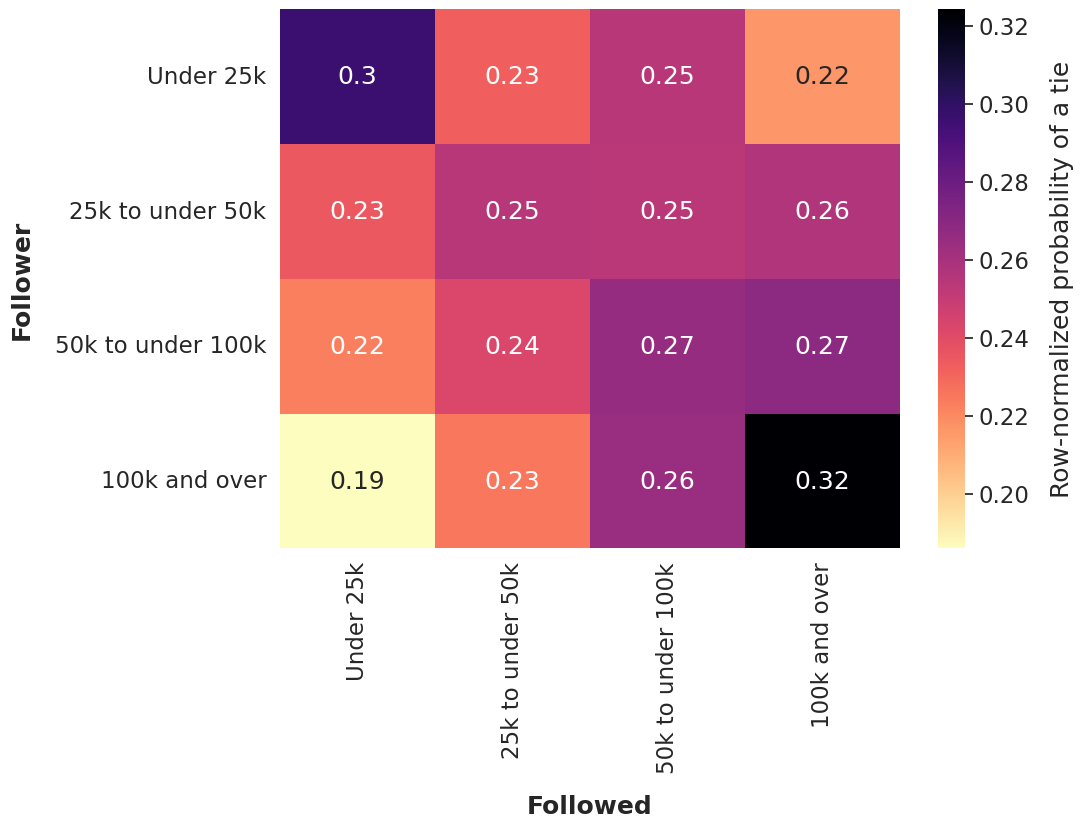

In [126]:
variable = "income_cat_4"
col_names=['Under 25k', '25k to under 50k','50k to under 100k','100k and over']
income = fn.get_table(fn.diadic_density(variable, G_flt_3)[0])
fn.genreate_heatmaps(variable, income, size=(10,7), col_names = col_names, title=False, font_scale=1.5,
                 annotate=True, labelpad=15, color= "magma_r", norm = "Row",
                 file_name='Plots/Bivariate/CSP/'+variable+'_rownorm_G3.png')


100%|█████████████████████████████████████████████████████████████████████████████████████| 2680/2680 [00:00<00:00, 125454.63it/s]
/home/quint/twitter_network/Soc science paper/homophily_functions.py:108: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  vals = pd.unique([pair[0] for pair in pairs])


(<Figure size 1000x700 with 2 Axes>,
 <Axes: xlabel='Followed', ylabel='Follower'>)

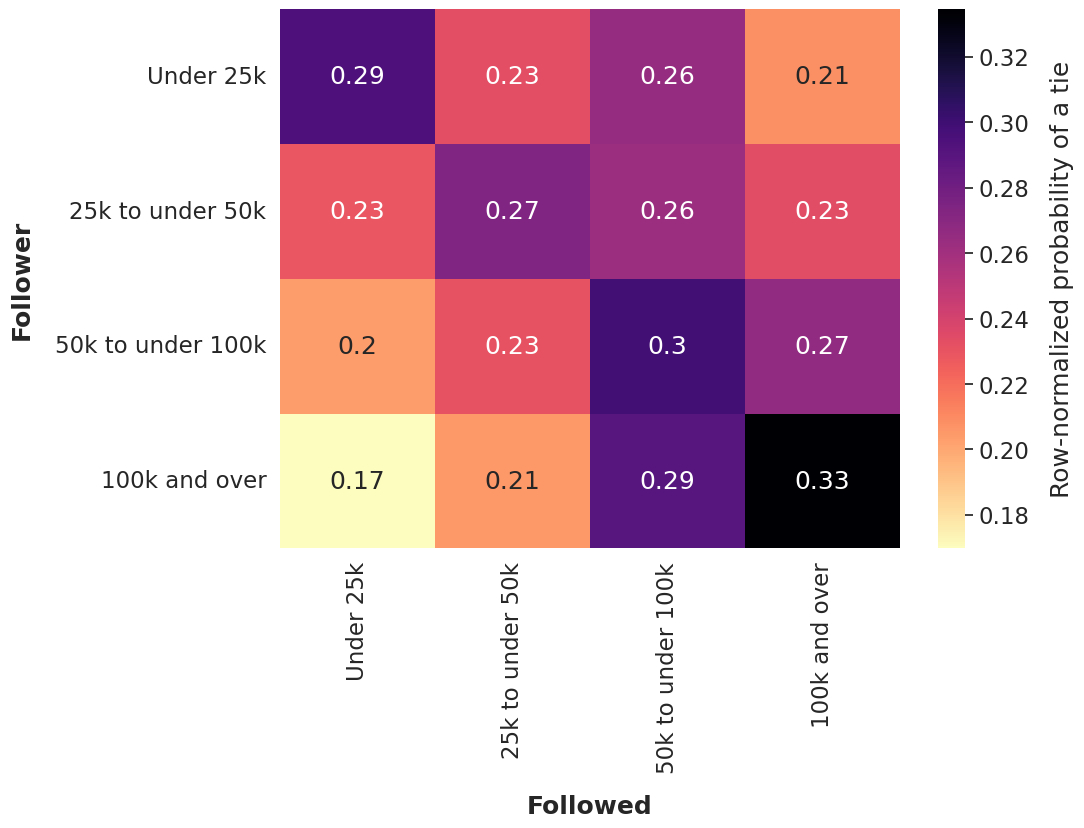

In [127]:
variable = "income_cat_4"
col_names=['Under 25k', '25k to under 50k','50k to under 100k','100k and over']
income = fn.get_table(fn.diadic_density(variable, G_flt_4)[0])
fn.genreate_heatmaps(variable, income, size=(10,7), col_names = col_names, title=False, font_scale=1.5,
                 annotate=True, labelpad=15, color= "magma_r", norm = "Row")
                 #file_name='plots/bivariate/covid_state/'+variable+'_rownorm_G3.png')